In [1]:
from typing import Literal
from pathlib import Path
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
from sklearn.neighbors import KernelDensity

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns

from load_utils import *

In [2]:
main_path = Path('./data')
player_df = get_player_lt(main_path)
player_df.head()

,noc,name,access_key,path
0,GER,nathalie_weinzierl,ger-nathalie_weinzierl,data/ger-nathalie_weinzierl
1,JPN,mao_asada,jpn-mao_asada,data/jpn-mao_asada
2,JPN,kanako_murakami,jpn-kanako_murakami,data/jpn-kanako_murakami
3,JPN,akiko_suzuki,jpn-akiko_suzuki,data/jpn-akiko_suzuki
4,USA,gracie_gold,usa-gracie_gold,data/usa-gracie_gold


In [3]:
history_path = Path('../olympic-historical-dataset')
result_df = pd.read_csv(history_path / 'Olympic_Results.csv')
event_df = pd.read_csv(history_path / 'Olympic_Athlete_Event_Results.csv')
df = pd.merge(event_df, result_df, how='left', on='result_id', suffixes=('', '_duplicate'))
df = df.drop(columns=[col for col in df.columns if col.endswith('_duplicate')])
figure_skating_df = df[df['sport'] == 'Figure Skating']
figure_skating_df.head()

,edition,edition_id,country_noc,sport,event,result_id,athlete,athlete_id,pos,medal,isTeamSport,event_title,sport_url,result_date,result_location,result_participants,result_format,result_detail,result_description
1867,1998 Winter Olympics,46,AZE,Figure Skating,"Singles, Men",14168,Igor Pashkevich,96229,16,NaN,False,"Singles, Men",/editions/46/sports/FSK,12 – 14 February 1998,"White Ring, Nagano",29 from 24 countries,"In each section, skaters were ranked on Ordina...",na,"Since Lillehammer, Elvis Stojko (CAN), silver ..."
1868,1998 Winter Olympics,46,AZE,Figure Skating,"Singles, Women",14189,Yuliya Vorobyova,82967,16,NaN,False,"Singles, Women",/editions/46/sports/FSK,18 – 20 February 1998,"White Ring, Nagano",28 from 21 countries,"In each section, skaters were ranked on Ordina...",na,Michelle Kwan had a chance to be on the 1994 U...
1869,1998 Winter Olympics,46,AZE,Figure Skating,"Pairs, Mixed",14210,Inga Rodionova,100207,18,NaN,True,"Pairs, Mixed",/editions/46/sports/FSK,8 – 10 February 1998,"White Ring, Nagano",40 from 14 countries,The pairs were ranked on Ordinal Placement for...,na,Artur Dmitriyev (RUS) had won the pairs gold m...
1870,1998 Winter Olympics,46,AZE,Figure Skating,"Pairs, Mixed",14210,Aleksandr Anishchenko,100208,18,NaN,True,"Pairs, Mixed",/editions/46/sports/FSK,8 – 10 February 1998,"White Ring, Nagano",40 from 14 countries,The pairs were ranked on Ordinal Placement for...,na,Artur Dmitriyev (RUS) had won the pairs gold m...
1904,2002 Winter Olympics,47,AZE,Figure Skating,"Singles, Men",14274,Sergey Rylov,101980,24,NaN,False,"Singles, Men",/editions/47/sports/FSK,12 – 14 February 2002,"Salt Lake Ice Center, Salt Lake City, Utah",28 from 20 countries,"In each section, skaters were ranked on Ordina...",na,"The co-favorites were the two Russians, Yevgen..."


In [4]:
pd.Series(figure_skating_df['edition'].unique()).sort_values().values

array(['1908 Summer Olympics', '1920 Summer Olympics',
       '1924 Winter Olympics', '1928 Winter Olympics',
       '1932 Winter Olympics', '1936 Winter Olympics',
       '1948 Winter Olympics', '1952 Winter Olympics',
       '1956 Winter Olympics', '1960 Winter Olympics',
       '1964 Winter Olympics', '1968 Winter Olympics',
       '1972 Winter Olympics', '1976 Winter Olympics',
       '1980 Winter Olympics', '1984 Winter Olympics',
       '1988 Winter Olympics', '1992 Winter Olympics',
       '1994 Winter Olympics', '1998 Winter Olympics',
       '2002 Winter Olympics', '2006 Winter Olympics',
       '2010 Winter Olympics', '2014 Winter Olympics',
       '2018 Winter Olympics', '2022 Winter Olympics'], dtype=object)

In [5]:
figure_skating_df['got-medal'] = (~ figure_skating_df['medal'].isna())
medal_count = figure_skating_df.groupby('country_noc')['got-medal'].sum().sort_values(ascending=False)
medal_count.head(30)

/var/folders/l4/xcb152_d5v51k4kx19t42f0w0000gn/T/ipykernel_29862/2954525174.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  figure_skating_df['got-medal'] = (~ figure_skating_df['medal'].isna())


country_noc
USA    101
CAN     65
RUS     52
URS     44
ROC     43
AUT     25
FRA     22
GER     21
JPN     20
GBR     20
CHN     16
GDR     14
HUN     12
SWE     10
EUN      9
NOR      7
TCH      5
FIN      4
ITA      3
NED      3
FRG      3
BEL      3
SUI      3
UKR      3
KOR      2
KAZ      1
ESP      1
SLO      0
TUR      0
SCG      0
Name: got-medal, dtype: int64

<Axes: xlabel='country_noc'>

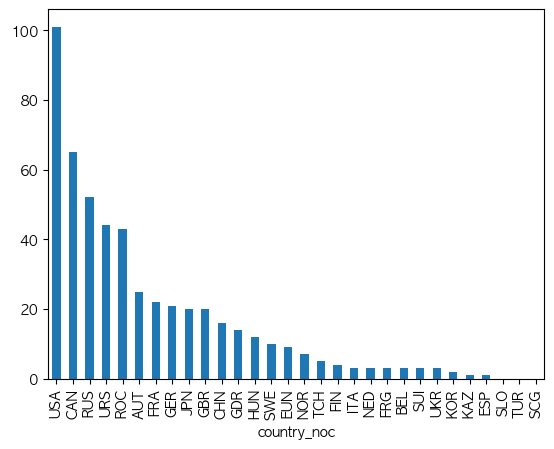

In [6]:
medal_count.head(30).plot.bar()

In [7]:
participated_countries = figure_skating_df[figure_skating_df['edition'].str.fullmatch('2014 Winter Olympics')]['country_noc'].unique()
participated_countries

array(['AZE', 'CZE', 'GEO', 'EST', 'BEL', 'BRA', 'ISR', 'AUT', 'KAZ',
       'LTU', 'AUS', 'PHI', 'CAN', 'GER', 'SVK', 'JPN', 'RUS', 'NOR',
       'KOR', 'ROU', 'CHN', 'UZB', 'GBR', 'ITA', 'FRA', 'TUR', 'UKR',
       'ESP', 'SWE', 'USA'], dtype=object)

In [8]:
sochi_country_medal_count = medal_count[participated_countries].sort_values(ascending=False)
sochi_country_medal_count

country_noc
USA    101
CAN     65
RUS     52
AUT     25
FRA     22
GER     21
GBR     20
JPN     20
CHN     16
SWE     10
NOR      7
UKR      3
ITA      3
BEL      3
KOR      2
KAZ      1
ESP      1
UZB      0
TUR      0
GEO      0
EST      0
ROU      0
LTU      0
CZE      0
SVK      0
BRA      0
ISR      0
PHI      0
AUS      0
AZE      0
Name: got-medal, dtype: int64

Text(0.5, 0, 'Country NOC')

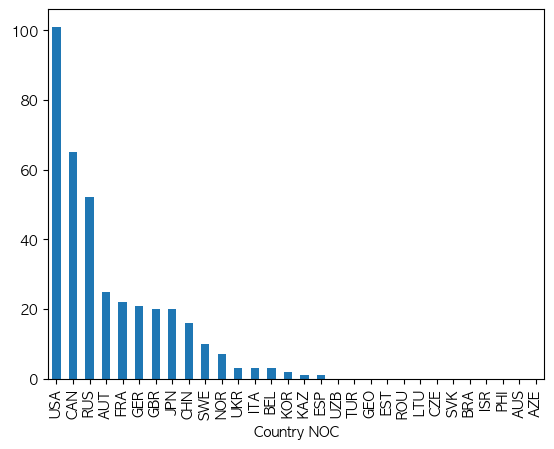

In [9]:
ax = sochi_country_medal_count.plot.bar()
ax.set_xlabel('Country NOC')

In [10]:
powerful_nations = sochi_country_medal_count[sochi_country_medal_count >= 20].index
powerful_nations = powerful_nations.tolist()

In [11]:
data = load_select_player_data(player_df['path'].tolist())
len(data.keys())

40

In [12]:
overview = dict()
for player_path in main_path.glob('*/*.csv'):
    overview[player_path.parent.name] = pd.read_csv(player_path, index_col=0)

In [13]:
for key in overview:
    overview[key]['event-key'] = overview[key]['season'].str.split('/').str[0].str.cat(overview[key]['event-title'], sep='-')

## Variance Comparison
2014 소치 올림픽 피겨 종목에 참여한 러시아 선수가 1명 뿐이라 ANOVA를 적용하기 어려웠음.

In [14]:
rus_df = player_df[player_df['noc'] == 'RUS']
rus_df

,noc,name,access_key,path
27,RUS,adelina_sotnikova,rus-adelina_sotnikova,data/rus-adelina_sotnikova


In [15]:
pd.Series(data['rus-adelina_sotnikova'].keys()).sort_values().values

array(['2008-RUS Nationals', '2009-RUS Nationals', '2010-JGP AUT',
       '2010-JGP Final', '2010-JGP GBR', '2010-Jr Worlds',
       '2010-RUS Nationals', '2011-GPCHN', '2011-GPRUS',
       '2011-Golden Spin', '2011-Jr Worlds', '2011-RUS Nationals',
       '2011-WTT', '2011-Youth Olys', '2012-Europeans', '2012-GPRUS',
       '2012-GPUSA', '2012-Nebelhorn', '2012-RUS Nationals', '2012-WTT',
       '2012-Worlds', '2013-Europeans', '2013-GPCHN', '2013-GPF',
       '2013-GPFRA', '2013-Japan Open', '2013-Olympics',
       '2013-RUS Nationals', '2014-RUS Cup 3', '2015-GPRUS',
       '2015-Golden Spin', '2015-Japan Open', '2015-Mordovian',
       '2015-RUS Nationals'], dtype=object)

In [16]:
data['rus-adelina_sotnikova']['2013-Olympics']['short_program']['PCS_tally_df']

,J0,J1,J2,J3,J4,J5,J6,J7,J8
score,38.2,34.2,36.0,35.4,35.2,35.8,37.4,32.6,34.8


In [17]:
def get_variance_df(data: dict, player_key: str):
    variance_df = []
    for event in data[player_key]:
        variance_df.append({
            'event': event,
            'short_program': float(np.var(data[player_key][event]['short_program']['PCS_tally_df'].values))
                                if (data[player_key][event]['short_program'] is not None
                                    and data[player_key][event]['short_program']['PCS_tally_df'] is not None
                                    )
                                else np.nan,
            'freeskating': float(np.var(data[player_key][event]['freeskating']['PCS_tally_df'].values))
                                if (data[player_key][event]['freeskating'] is not None
                                    and data[player_key][event]['freeskating']['PCS_tally_df'] is not None
                                    )
                                else np.nan,
        })
    variance_df = pd.DataFrame(variance_df)
    variance_df = variance_df.set_index('event', drop=True).sort_index()
    return variance_df

In [18]:
sotnikova_variance = get_variance_df(data, 'rus-adelina_sotnikova')
sotnikova_variance

,short_program,freeskating
event,,
2008-RUS Nationals,NaN,NaN
2009-RUS Nationals,NaN,NaN
2010-JGP AUT,1.977284,7.909136
2010-JGP Final,1.120988,4.657778
2010-JGP GBR,4.862222,7.751111
2010-Jr Worlds,1.817284,1.402469
2010-RUS Nationals,NaN,NaN
2011-GPCHN,2.993580,5.550617
2011-GPRUS,5.386667,8.181728


In [19]:
def draw_outlier_label(ax, data: pd.DataFrame, col: str, x_coord: float):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    outlier_upper_bound = q3 + 1.5 * (q3 - q1)
    outlier_lower_bound = q1 - 1.5 * (q3 - q1)
    outliers = data[(data[col] < outlier_lower_bound) | (data[col] > outlier_upper_bound)]
    for idx_event, row in outliers.iterrows():
        y_val = row[col]
        ax.text(x_coord, y_val,
                 idx_event, 
                 va='center', 
                 fontsize=5, 
                 color='black')

In [20]:
def draw_boxplot_outlier_label(data: pd.DataFrame, ax=None, title=None):
    ax = sns.boxplot(data, ax=ax)
    draw_outlier_label(ax, data, 'short_program', 0.05)
    draw_outlier_label(ax, data, 'freeskating', 1.05)
    if title is not None:
        ax.set_title(title)
    return ax

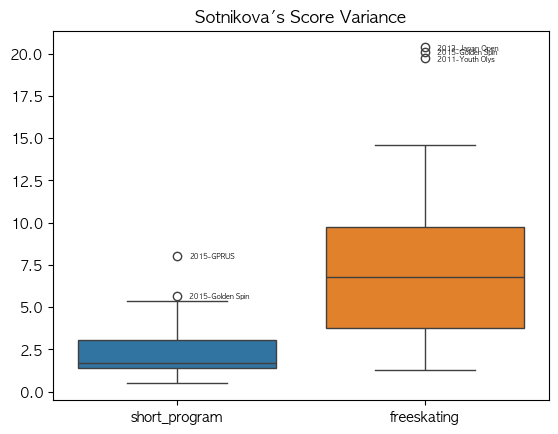

In [21]:
ax = draw_boxplot_outlier_label(sotnikova_variance, title="Sotnikova's Score Variance")

In [22]:
def get_mean_df(data: dict, player_key: str):
    mean_df = []
    for event in data[player_key]:
        mean_df.append({
            'event': event,
            'short_program': float(np.mean(data[player_key][event]['short_program']['PCS_tally_df'].values))
                                if (data[player_key][event]['short_program'] is not None
                                    and data[player_key][event]['short_program']['PCS_tally_df'] is not None
                                    )
                                else np.nan,
            'freeskating': float(np.mean(data[player_key][event]['freeskating']['PCS_tally_df'].values))
                                if (data[player_key][event]['freeskating'] is not None
                                    and data[player_key][event]['freeskating']['PCS_tally_df'] is not None
                                    )
                                else np.nan,
        })
    mean_df = pd.DataFrame(mean_df)
    mean_df = mean_df.set_index('event', drop=True).sort_index()
    return mean_df

In [23]:
sotnikova_mean = get_mean_df(data, 'rus-adelina_sotnikova')
sotnikova_mean.head()

,short_program,freeskating
event,,
2008-RUS Nationals,NaN,NaN
2009-RUS Nationals,NaN,NaN
2010-JGP AUT,25.177778,54.355556
2010-JGP Final,25.711111,53.733333
2010-JGP GBR,25.000000,51.066667


<Axes: title={'center': "Sotnikova's Score Mean"}>

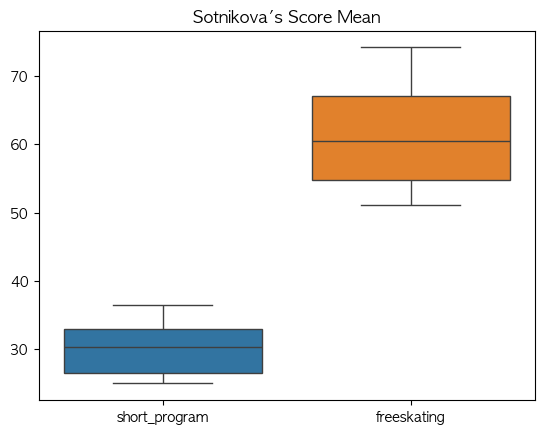

In [24]:
draw_boxplot_outlier_label(sotnikova_mean, title="Sotnikova's Score Mean")

<Axes: title={'center': "Sotnikova's Score Variance"}>

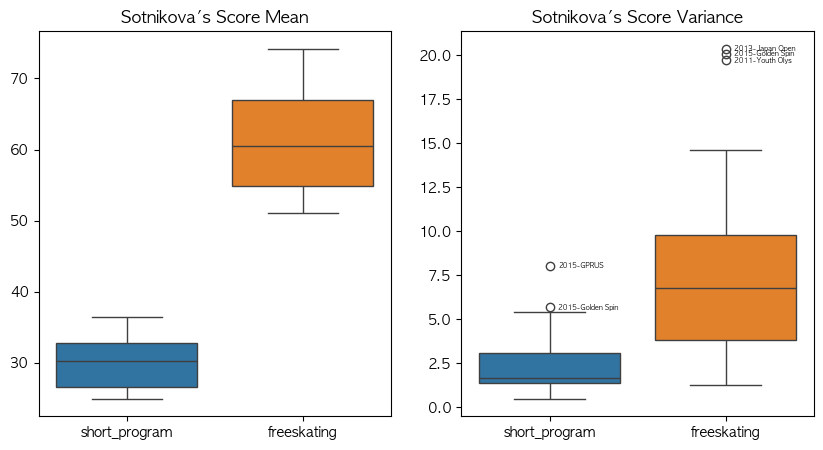

In [25]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
draw_boxplot_outlier_label(sotnikova_mean, title="Sotnikova's Score Mean", ax=axes[0])
draw_boxplot_outlier_label(sotnikova_variance, title="Sotnikova's Score Variance", ax=axes[1])

In [26]:
kim_yuna_variance = get_variance_df(data, 'kor-yuna_kim')
kim_yuna_variance

,short_program,freeskating
event,,
2004-JGP CHN,65.716543,450.349136
2004-JGP Final,110.085100,560.559500
2004-JGP HUN,79.400000,580.981100
2004-Jr Worlds,109.128889,614.886389
2005-JGP BUL,120.516400,575.475600
2005-JGP Final,149.613900,692.421600
2005-JGP SVK,139.161111,659.201111
2005-Jr Worlds,138.943264,655.592222
2006-GPCAN,124.419500,674.093900


<Axes: >

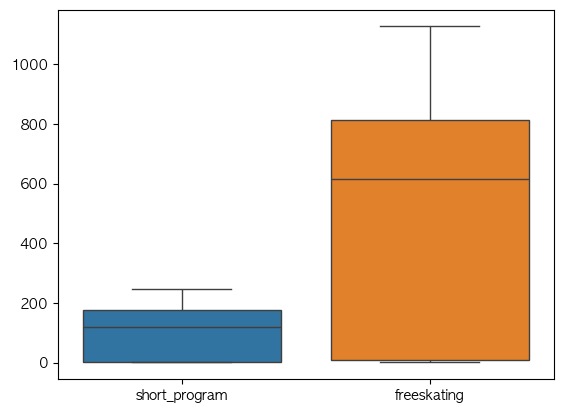

In [27]:
draw_boxplot_outlier_label(kim_yuna_variance)

In [28]:
kim_yuna_mean = get_mean_df(data, 'kor-yuna_kim')
kim_yuna_mean.head()

,short_program,freeskating
event,,
2004-JGP CHN,11.888889,22.644444
2004-JGP Final,13.130000,25.850000
2004-JGP HUN,13.800000,25.030000
2004-Jr Worlds,13.766667,27.216667
2005-JGP BUL,12.660000,24.980000


<Axes: >

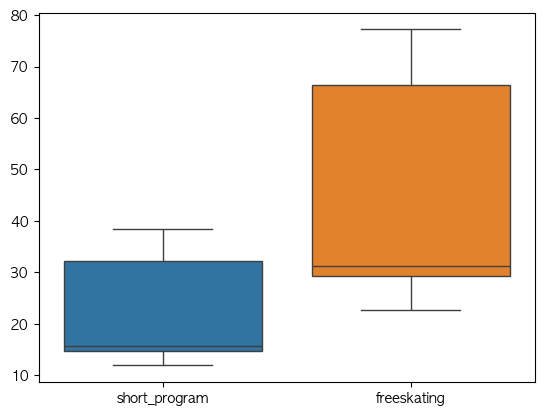

In [29]:
draw_boxplot_outlier_label(kim_yuna_mean)

<Axes: title={'center': "Kim Yuna's Score Variance"}>

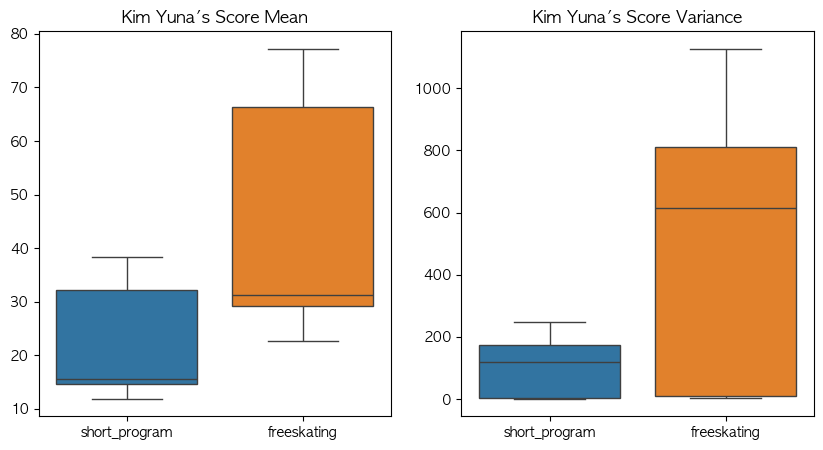

In [30]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
draw_boxplot_outlier_label(kim_yuna_mean, title="Kim Yuna's Score Mean", ax=axes[0])
draw_boxplot_outlier_label(kim_yuna_variance, title="Kim Yuna's Score Variance", ax=axes[1])

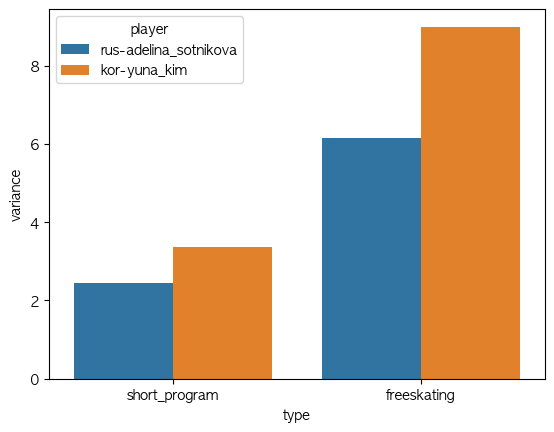

In [31]:
_ = sns.barplot(
    data=pd.DataFrame({
        'player': ['rus-adelina_sotnikova'] * 2 + ['kor-yuna_kim'] * 2,
        'type': ['short_program', 'freeskating'] * 2,
        'variance': [
            sotnikova_variance.loc['2013-Olympics', 'short_program'],
            sotnikova_variance.loc['2013-Olympics', 'freeskating'],
            kim_yuna_variance.loc['2013-Olympics', 'short_program'],
            kim_yuna_variance.loc['2013-Olympics', 'freeskating'],
        ]
    }),
    x='type',
    y='variance',
    hue='player'
)

In [32]:
PCS_mean_lt = []
for i, row in player_df.iterrows():
    player_key = row['access_key']
    noc = row['noc']
    # Freeskating 까지 올라간 선수들만 비교
    if data[player_key]['2013-Olympics']['freeskating'] is not None:
        PCS_mean_lt.append({
            'noc': noc,
            'name': player_key,
            'type': 'short_programs',
            'mean': float(np.mean(data[player_key]['2013-Olympics']['short_program']['PCS_tally_df'].values[:, :-1]))
        })
        PCS_mean_lt.append({
            'noc': noc,
            'name': player_key,
            'type': 'freeskating',
            'mean': float(np.mean(data[player_key]['2013-Olympics']['freeskating']['PCS_tally_df'].values[:, :-1]))
        })
PCS_mean_df = pd.DataFrame(PCS_mean_lt)
PCS_mean_df.head()

,noc,name,type,mean
0,GER,ger-nathalie_weinzierl,short_programs,26.000
1,GER,ger-nathalie_weinzierl,freeskating,52.600
2,JPN,jpn-mao_asada,short_programs,33.775
3,JPN,jpn-mao_asada,freeskating,69.550
4,JPN,jpn-kanako_murakami,short_programs,29.225


Text(0.5, 1.0, 'Avg. of 2014 Olympics Scores')

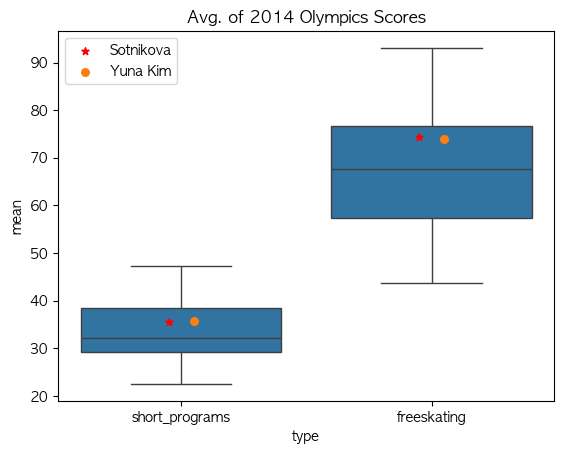

In [33]:
ax = sns.boxplot(PCS_mean_df, x='type', y='mean')
ax.scatter(-0.05, PCS_mean_df[(PCS_mean_df['name'] == 'rus-adelina_sotnikova') & (PCS_mean_df['type'] == 'short_programs')]['mean'], color="red", s=30, zorder=3, marker='*').set_label('Sotnikova')
ax.scatter(0.95, PCS_mean_df[(PCS_mean_df['name'] == 'rus-adelina_sotnikova') & (PCS_mean_df['type'] == 'freeskating')]['mean'], color="red", s=30, zorder=3, marker='*')
ax.scatter(0.05, PCS_mean_df[(PCS_mean_df['name'] == 'kor-yuna_kim') & (PCS_mean_df['type'] == 'short_programs')]['mean'], color=sns.color_palette()[1], s=30, zorder=3, marker='o').set_label('Yuna Kim')
ax.scatter(1.05, PCS_mean_df[(PCS_mean_df['name'] == 'kor-yuna_kim') & (PCS_mean_df['type'] == 'freeskating')]['mean'], color=sns.color_palette()[1], s=30, zorder=3, marker='o')
ax.legend()
ax.set_title('Avg. of 2014 Olympics Scores')

In [34]:
PCS_std_lt = []
for i, row in player_df.iterrows():
    player_key = row['access_key']
    noc = row['noc']
    # Freeskating 까지 올라간 선수들만 비교
    if data[player_key]['2013-Olympics']['freeskating'] is not None:
        PCS_std_lt.append({
            'noc': noc,
            'name': player_key,
            'type': 'short_programs',
            'std': float(np.std(data[player_key]['2013-Olympics']['short_program']['PCS_tally_df'].values[:, :-1]))
        })
        PCS_std_lt.append({
            'noc': noc,
            'name': player_key,
            'type': 'freeskating',
            'std': float(np.std(data[player_key]['2013-Olympics']['freeskating']['PCS_tally_df'].values[:, :-1]))
        })
PCS_std_df = pd.DataFrame(PCS_std_lt)
PCS_std_df.head()

,noc,name,type,std
0,GER,ger-nathalie_weinzierl,short_programs,1.122497
1,GER,ger-nathalie_weinzierl,freeskating,1.949359
2,JPN,jpn-mao_asada,short_programs,1.508103
3,JPN,jpn-mao_asada,freeskating,2.887473
4,JPN,jpn-kanako_murakami,short_programs,1.440269


In [35]:
PCS_std_df.loc[:, 'Russia'] = 'Not Russia'
PCS_std_df.loc[PCS_std_df['noc'] == 'RUS', 'Russia'] = 'Russia'

Text(0.5, 1.0, 'Std. of 2014 Olympics Scores')

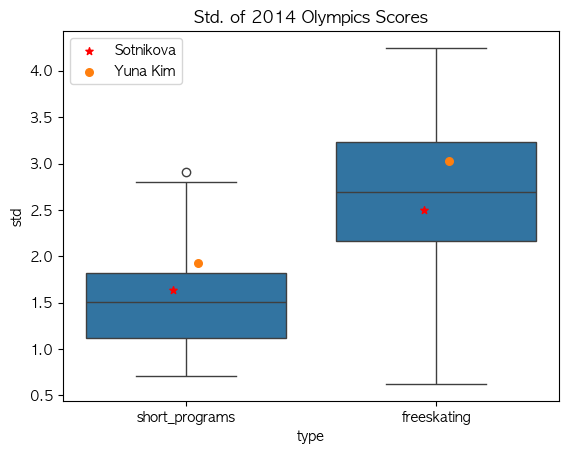

In [36]:
ax = sns.boxplot(PCS_std_df, x='type', y='std')
ax.scatter(-0.05, PCS_std_df[(PCS_std_df['name'] == 'rus-adelina_sotnikova') & (PCS_std_df['type'] == 'short_programs')]['std'], color="red", s=30, zorder=3, marker='*').set_label('Sotnikova')
ax.scatter(0.95, PCS_std_df[(PCS_std_df['name'] == 'rus-adelina_sotnikova') & (PCS_std_df['type'] == 'freeskating')]['std'], color="red", s=30, zorder=3, marker='*')
ax.scatter(0.05, PCS_std_df[(PCS_std_df['name'] == 'kor-yuna_kim') & (PCS_std_df['type'] == 'short_programs')]['std'], color=sns.color_palette()[1], s=30, zorder=3, marker='o').set_label('Yuna Kim')
ax.scatter(1.05, PCS_std_df[(PCS_std_df['name'] == 'kor-yuna_kim') & (PCS_std_df['type'] == 'freeskating')]['std'], color=sns.color_palette()[1], s=30, zorder=3, marker='o')
ax.legend()
ax.set_title('Std. of 2014 Olympics Scores')

Text(0.5, 1.0, 'Std. of 2014 Olympics Scores')

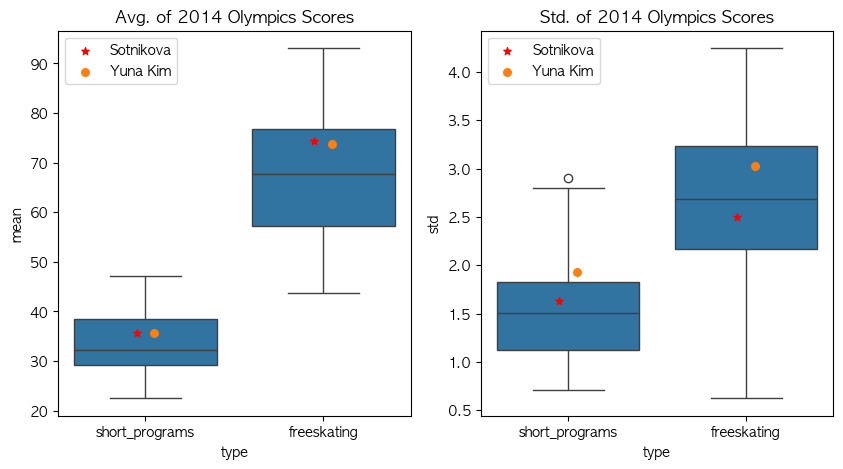

In [37]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
sns.boxplot(PCS_mean_df, x='type', y='mean', ax=axes[0])
axes[0].scatter(-0.05, PCS_mean_df[(PCS_mean_df['name'] == 'rus-adelina_sotnikova') & (PCS_mean_df['type'] == 'short_programs')]['mean'], color="red", s=30, zorder=3, marker='*').set_label('Sotnikova')
axes[0].scatter(0.95, PCS_mean_df[(PCS_mean_df['name'] == 'rus-adelina_sotnikova') & (PCS_mean_df['type'] == 'freeskating')]['mean'], color="red", s=30, zorder=3, marker='*')
axes[0].scatter(0.05, PCS_mean_df[(PCS_mean_df['name'] == 'kor-yuna_kim') & (PCS_mean_df['type'] == 'short_programs')]['mean'], color=sns.color_palette()[1], s=30, zorder=3, marker='o').set_label('Yuna Kim')
axes[0].scatter(1.05, PCS_mean_df[(PCS_mean_df['name'] == 'kor-yuna_kim') & (PCS_mean_df['type'] == 'freeskating')]['mean'], color=sns.color_palette()[1], s=30, zorder=3, marker='o')
axes[0].legend()
axes[0].set_title('Avg. of 2014 Olympics Scores')

sns.boxplot(PCS_std_df, x='type', y='std', ax=axes[1])
axes[1].scatter(-0.05, PCS_std_df[(PCS_std_df['name'] == 'rus-adelina_sotnikova') & (PCS_std_df['type'] == 'short_programs')]['std'], color="red", s=30, zorder=3, marker='*').set_label('Sotnikova')
axes[1].scatter(0.95, PCS_std_df[(PCS_std_df['name'] == 'rus-adelina_sotnikova') & (PCS_std_df['type'] == 'freeskating')]['std'], color="red", s=30, zorder=3, marker='*')
axes[1].scatter(0.05, PCS_std_df[(PCS_std_df['name'] == 'kor-yuna_kim') & (PCS_std_df['type'] == 'short_programs')]['std'], color=sns.color_palette()[1], s=30, zorder=3, marker='o').set_label('Yuna Kim')
axes[1].scatter(1.05, PCS_std_df[(PCS_std_df['name'] == 'kor-yuna_kim') & (PCS_std_df['type'] == 'freeskating')]['std'], color=sns.color_palette()[1], s=30, zorder=3, marker='o')
axes[1].legend()
axes[1].set_title('Std. of 2014 Olympics Scores')

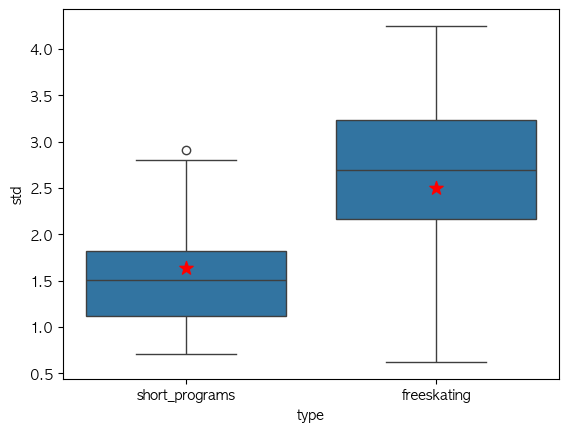

In [38]:
ax = sns.boxplot(PCS_std_df, x='type', y='std')
ax.scatter(0, PCS_std_df[(PCS_std_df['name'] == 'rus-adelina_sotnikova') & (PCS_std_df['type'] == 'short_programs')]['std'], color="red", s=100, zorder=3, marker='*')
ax.scatter(1, PCS_std_df[(PCS_std_df['name'] == 'rus-adelina_sotnikova') & (PCS_std_df['type'] == 'freeskating')]['std'], color="red", s=100, zorder=3, marker='*')

In [39]:
pd.DataFrame(PCS_std_df.groupby(['Russia', 'type'])['std'].mean())

std
Russia     type                    
Not Russia freeskating     2.722302
           short_programs  1.581410
Russia     freeskating     2.501500
           short_programs  1.634013

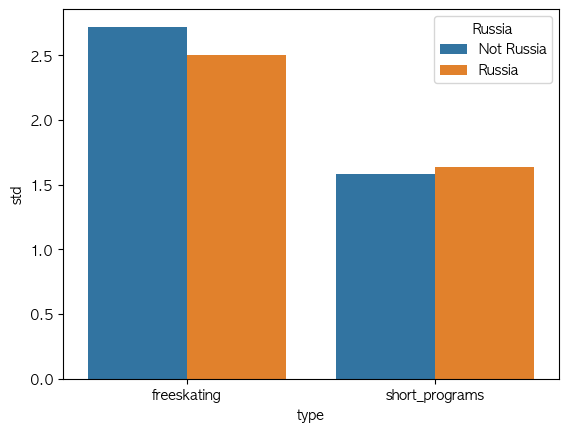

In [40]:
_ = sns.barplot(
    pd.DataFrame(PCS_std_df.groupby(['Russia', 'type'])['std'].mean()), 
    x='type', 
    y='std', 
    hue='Russia',
)

In [41]:
TES_std_lt = []
for i, row in player_df.iterrows():
    player_key = row['access_key']
    noc = row['noc']
    # Freeskating 까지 올라간 선수들만 비교
    if (data[player_key]['2013-Olympics']['freeskating'] is not None
        and data[player_key]['2013-Olympics']['short_program']['total'].values.shape == data[player_key]['2013-Olympics']['short_program']['PCS_tally_df'].values[:, :-1].shape
        and data[player_key]['2013-Olympics']['freeskating']['total'].values.shape == data[player_key]['2013-Olympics']['freeskating']['PCS_tally_df'].values[:, :-1].shape
    ):
        TES_std_lt.append({
            'noc': noc,
            'name': player_key,
            'type': 'short_programs',
            'std': float(np.std(
                data[player_key]['2013-Olympics']['short_program']['total'].values
                - data[player_key]['2013-Olympics']['short_program']['PCS_tally_df'].values[:, :-1]
            ))
        })
        TES_std_lt.append({
            'noc': noc,
            'name': player_key,
            'type': 'freeskating',
            'std': float(np.std(
                data[player_key]['2013-Olympics']['freeskating']['total'].values
                - data[player_key]['2013-Olympics']['freeskating']['PCS_tally_df'].values[:, :-1]
            ))
        })
    #else:
    #    print(
    #        data[player_key]['Olympics']['short_program']['total'].shape, data[player_key]['Olympics']['short_program']['PCS_tally_df'].shape,
    #        data[player_key]['Olympics']['freeskating']['total'].shape, data[player_key]['Olympics']['freeskating']['PCS_tally_df'].shape,
    #    )
TES_std_df = pd.DataFrame(TES_std_lt)
TES_std_df

,noc,name,type,std
0,GER,ger-nathalie_weinzierl,short_programs,1.983329
1,GER,ger-nathalie_weinzierl,freeskating,3.479022
2,JPN,jpn-mao_asada,short_programs,2.073493
3,JPN,jpn-mao_asada,freeskating,5.577634
4,JPN,jpn-kanako_murakami,short_programs,3.122074
...,...,...,...,...
61,FRA,fra-brian_joubert,freeskating,4.445785
62,ISR,isr-alexei_bychenko,short_programs,2.362128
63,ISR,isr-alexei_bychenko,freeskating,5.989561
64,JPN,jpn-tatsuki_machida,short_programs,3.291365


In [42]:
TES_std_df.loc[:, 'Russia'] = 'Not Russia'
TES_std_df.loc[TES_std_df['noc'] == 'RUS', 'Russia'] = 'Russia'

In [43]:
pd.DataFrame(TES_std_df.groupby(['Russia', 'type'])['std'].mean())

std
Russia     type                    
Not Russia freeskating     4.937999
           short_programs  3.005716
Russia     freeskating     6.507688
           short_programs  3.193132

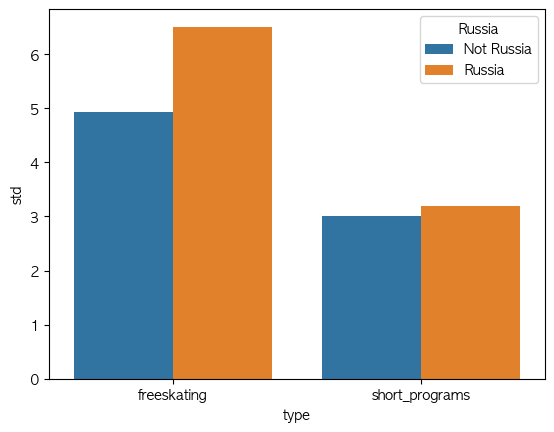

In [44]:
_ = sns.barplot(
    pd.DataFrame(TES_std_df.groupby(['Russia', 'type'])['std'].mean()), 
    x='type', 
    y='std', 
    hue='Russia',
)

## Sotnikova 분석

In [45]:
sotnikova = data['rus-adelina_sotnikova']
index_lt = pd.Series(sotnikova.keys()).sort_values().tolist()
index_lt

['2008-RUS Nationals',
 '2009-RUS Nationals',
 '2010-JGP AUT',
 '2010-JGP Final',
 '2010-JGP GBR',
 '2010-Jr Worlds',
 '2010-RUS Nationals',
 '2011-GPCHN',
 '2011-GPRUS',
 '2011-Golden Spin',
 '2011-Jr Worlds',
 '2011-RUS Nationals',
 '2011-WTT',
 '2011-Youth Olys',
 '2012-Europeans',
 '2012-GPRUS',
 '2012-GPUSA',
 '2012-Nebelhorn',
 '2012-RUS Nationals',
 '2012-WTT',
 '2012-Worlds',
 '2013-Europeans',
 '2013-GPCHN',
 '2013-GPF',
 '2013-GPFRA',
 '2013-Japan Open',
 '2013-Olympics',
 '2013-RUS Nationals',
 '2014-RUS Cup 3',
 '2015-GPRUS',
 '2015-Golden Spin',
 '2015-Japan Open',
 '2015-Mordovian',
 '2015-RUS Nationals']

In [46]:
sotnikova_overivew = overview['rus-adelina_sotnikova']
sotnikova_overivew.head()

,season,event-title,event-url,location,date,short-program-link,short-program-score,short-program-ranking,freeskating-link,freeskating-score,freeskating-ranking,final-link,final-score,final-ranking,event-key
0,2008/09,RUS Nationals,https://skatingscores.com/0809/natrus/,Kazan,2008-12-01,https://skatingscores.com/0809/natrus/sr/women...,54.93,1,https://skatingscores.com/0809/natrus/sr/women...,105.62,2,https://skatingscores.com/0809/natrus/sr/women...,160.55,1,2008-RUS Nationals
1,2009/10,RUS Nationals,https://skatingscores.com/0910/natrus/,St. Petersburg,2009-12-23,https://skatingscores.com/0910/natrus/sr/women...,59.77,3,https://skatingscores.com/0910/natrus/sr/women...,112.92,4,https://skatingscores.com/0910/natrus/sr/women...,172.69,4,2009-RUS Nationals
2,2009/10,RUS Nationals,https://skatingscores.com/0910/natrus/,Saransk,2010-02-03,https://skatingscores.com/0910/natrus/jr/women...,57.28,4J,https://skatingscores.com/0910/natrus/jr/women...,93.50,6J,https://skatingscores.com/0910/natrus/jr/women...,150.78,6J,2009-RUS Nationals
3,2010/11,JGP AUT,https://skatingscores.com/1011/jgpaut/,Graz,2010-09-15,https://skatingscores.com/1011/jgpaut/jr/women...,61.32,1J,https://skatingscores.com/1011/jgpaut/jr/women...,117.65,1J,https://skatingscores.com/1011/jgpaut/jr/women...,178.97,1J,2010-JGP AUT
4,2010/11,JGP GBR,https://skatingscores.com/1011/jgpgbr/,Sheffield,2010-09-29,https://skatingscores.com/1011/jgpgbr/jr/women...,59.39,1J,https://skatingscores.com/1011/jgpgbr/jr/women...,107.31,1J,https://skatingscores.com/1011/jgpgbr/jr/women...,166.70,1J,2010-JGP GBR


In [47]:
sotnikova_std = []
for index in index_lt:
    sotnikova_std.append({
        'event-title': index,
        'type': 'short_program',
        'TES_std': float(np.std(
            data[player_key]['2013-Olympics']['short_program']['total'].values
            - data[player_key]['2013-Olympics']['short_program']['PCS_tally_df'].values[:, :-1]
        )),
        'PCS_std': float(np.std(
            data[player_key]['2013-Olympics']['short_program']['PCS_tally_df'].values
        ))
    })

    if (
        data[player_key]['2013-Olympics']['freeskating'] is not None
        and data[player_key]['2013-Olympics']['freeskating']['PCS_tally_df'] is not None
        and data[player_key]['2013-Olympics']['freeskating']['total'] is not None
    ):
        sotnikova_std.append({
            'event-title': index,
            'type': 'freeskating',
            'TES_std': float(np.std(
                data[player_key]['2013-Olympics']['freeskating']['total'].values
                - data[player_key]['2013-Olympics']['freeskating']['PCS_tally_df'].values[:, :-1]
            )),
            'PCS_std': float(np.std(
                data[player_key]['2013-Olympics']['freeskating']['PCS_tally_df'].values
            ))
        })
sotnikova_std = pd.DataFrame(sotnikova_std)
sotnikova_std.head()

,event-title,type,TES_std,PCS_std
0,2008-RUS Nationals,short_program,3.291365,1.274755
1,2008-RUS Nationals,freeskating,2.953361,1.825742
2,2009-RUS Nationals,short_program,3.291365,1.274755
3,2009-RUS Nationals,freeskating,2.953361,1.825742
4,2010-JGP AUT,short_program,3.291365,1.274755


In [48]:
sotnikova_std.groupby('type').describe().T

type           freeskating  short_program
TES_std count    34.000000   3.400000e+01
        mean      2.953361   3.291365e+00
        std       0.000000   0.000000e+00
        min       2.953361   3.291365e+00
        25%       2.953361   3.291365e+00
        50%       2.953361   3.291365e+00
        75%       2.953361   3.291365e+00
        max       2.953361   3.291365e+00
PCS_std count    34.000000   3.400000e+01
        mean      1.825742   1.274755e+00
        std       0.000000   2.253838e-16
        min       1.825742   1.274755e+00
        25%       1.825742   1.274755e+00
        50%       1.825742   1.274755e+00
        75%       1.825742   1.274755e+00
        max       1.825742   1.274755e+00

In [49]:
sotnikova_overivew.columns

Index(['season', 'event-title', 'event-url', 'location', 'date',
       'short-program-link', 'short-program-score', 'short-program-ranking',
       'freeskating-link', 'freeskating-score', 'freeskating-ranking',
       'final-link', 'final-score', 'final-ranking', 'event-key'],
      dtype='object')

In [50]:
'''
sotnikova_overivew['event-title'] = sotnikova_overivew['season'].str.split('/').str[0].str.cat(sotnikova_overivew['event-title'], sep='-')
sotnikova_overivew = sotnikova_overivew.drop(columns=['season'])
sotnikova_overivew.head()
'''

"\nsotnikova_overivew['event-title'] = sotnikova_overivew['season'].str.split('/').str[0].str.cat(sotnikova_overivew['event-title'], sep='-')\nsotnikova_overivew = sotnikova_overivew.drop(columns=['season'])\nsotnikova_overivew.head()\n"

In [51]:
sotnikova_overivew['season'] == '2014'

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
Name: season, dtype: bool

<Axes: xlabel='season', ylabel='final-score'>

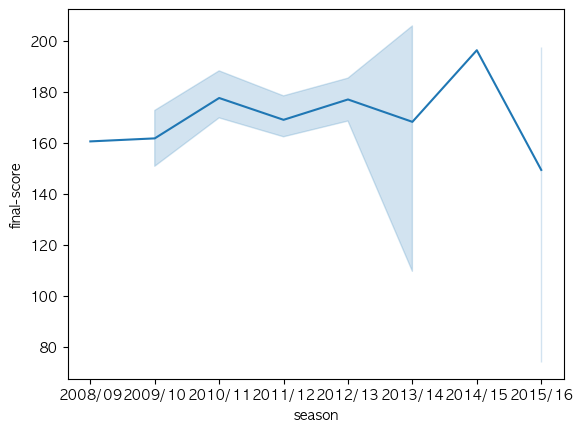

In [52]:
sns.lineplot(sotnikova_overivew[['season', 'final-score']], x='season', y='final-score')

## KL Divergence Measurements

In [53]:
x = np.linspace(0, 100, 5_000).reshape(-1, 1)
none_cnt = 0
def get_kde(score_data: np.ndarray):
    kde = KernelDensity().fit(score_data.reshape(-1, 1))
    return np.exp(kde.score_samples(x))

def get_total_kde(data: dict, player_key: str, event_type: Literal['short_program', 'freeskating'], event: str='2013-Olympics'):
    global none_cnt
    result = dict()
    if (data[player_key][event][event_type] is not None
        and data[player_key][event][event_type]['total'] is not None
        and data[player_key][event][event_type]['PCS_tally_df'] is not None
        and data[player_key][event][event_type]['total'].values.shape == data[player_key][event][event_type]['PCS_tally_df'].values[:, :-1].shape
    ):
        result['TES'] = get_kde(
            data[player_key][event][event_type]['total'].values
            - data[player_key][event][event_type]['PCS_tally_df'].values[:, :-1]
        )
    else:
        result['TES'] = np.zeros_like(x)
        none_cnt += 1

    if (data[player_key][event][event_type] is not None
        and data[player_key][event][event_type]['PCS_tally_df'] is not None
    ):
        result['PCS'] = get_kde(data[player_key][event][event_type]['PCS_tally_df'].values)
    else:
        result['PCS'] = np.zeros_like(x)
        none_cnt += 1
    return result

In [54]:
kld_df = []
for player_key in data:
    short_program_row = get_total_kde(data, player_key, 'short_program')
    freeskating_row = get_total_kde(data, player_key, 'freeskating')
    kld_df.append({
        'player_key': player_key,
        'short_program_TES': short_program_row['TES'],
        'short_program_PCS': short_program_row['PCS'],
        'freeskating_TES': freeskating_row['TES'],
        'freeskating_PCS': freeskating_row['PCS'],
    })
kld_df = pd.DataFrame(kld_df)
kld_df.head()

,player_key,short_program_TES,short_program_PCS,freeskating_TES,freeskating_PCS
0,ger-nathalie_weinzierl,"[1.6287688526745763e-182, 2.8989270795145257e-...","[5.879448445651712e-119, 9.349806933750959e-11...","[9.316603419730248e-226, 1.7709948573995466e-2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,jpn-mao_asada,"[1.1256677720307537e-70, 1.606162010814705e-70...","[9.293279562062964e-211, 1.727422413377443e-21...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,jpn-kanako_murakami,"[3.2228649885571046e-102, 4.951833664177303e-1...","[2.0124567267733346e-153, 3.4118742382418623e-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,jpn-akiko_suzuki,"[3.6784734814131645e-139, 6.079961181718778e-1...","[3.9783035641556404e-200, 7.277418752780603e-2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,usa-gracie_gold,"[4.403490123146987e-258, 8.751255702406602e-25...","[4.49787259157325e-208, 8.327272362324939e-208...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [55]:
kld_df = kld_df.set_index('player_key', drop=True)
kld_df.head()

,short_program_TES,short_program_PCS,freeskating_TES,freeskating_PCS
player_key,,,,
ger-nathalie_weinzierl,"[1.6287688526745763e-182, 2.8989270795145257e-...","[5.879448445651712e-119, 9.349806933750959e-11...","[9.316603419730248e-226, 1.7709948573995466e-2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
jpn-mao_asada,"[1.1256677720307537e-70, 1.606162010814705e-70...","[9.293279562062964e-211, 1.727422413377443e-21...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
jpn-kanako_murakami,"[3.2228649885571046e-102, 4.951833664177303e-1...","[2.0124567267733346e-153, 3.4118742382418623e-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
jpn-akiko_suzuki,"[3.6784734814131645e-139, 6.079961181718778e-1...","[3.9783035641556404e-200, 7.277418752780603e-2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
usa-gracie_gold,"[4.403490123146987e-258, 8.751255702406602e-25...","[4.49787259157325e-208, 8.327272362324939e-208...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [56]:
len(kld_df), none_cnt

(40, 14)

In [57]:
ref_dist = {
    'short_program_TES': kld_df[kld_df['short_program_TES'].apply(np.sum) > 0.1]['short_program_TES'].sum(),
    'short_program_PCS': kld_df[kld_df['short_program_PCS'].apply(np.sum) > 0.1]['short_program_PCS'].sum(),
    'freeskating_TES': kld_df[kld_df['freeskating_TES'].apply(np.sum) > 0.1]['freeskating_TES'].sum(),
    'freeskating_PCS': kld_df[kld_df['freeskating_PCS'].apply(np.sum) > 0.1]['freeskating_PCS'].sum(),
}
ref_dist

{'short_program_TES': array([3.40470650e-41, 4.45315302e-41, 5.82212828e-41, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00], shape=(5000,)),
 'short_program_PCS': array([3.40893739e-85, 5.04459638e-85, 7.46208347e-85, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00], shape=(5000,)),
 'freeskating_TES': array([1.81704406e-225, 3.45334918e-225, 6.56057280e-225, ...,
        9.69874424e-009, 8.67544308e-009, 7.75701654e-009], shape=(5000,)),
 'freeskating_PCS': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.32882189e-06, 2.12771676e-06, 1.94321736e-06], shape=(5000,))}

In [58]:
kld_result = []
for player_key, row in tqdm(kld_df.iterrows(), total=len(kld_df)):
    kld_result.append({
        'player_key': player_key,
        'short_program_TES': stats.entropy(row['short_program_TES'], ref_dist['short_program_TES']) if row['short_program_TES'].sum() > 0.1 else np.nan,
        'short_program_PCS': stats.entropy(row['short_program_PCS'], ref_dist['short_program_PCS']) if row['short_program_PCS'].sum() > 0.1 else np.nan,
        'freeskating_PCS': stats.entropy(row['freeskating_PCS'], ref_dist['freeskating_PCS']) if row['freeskating_PCS'].sum() > 0.1 else np.nan,
        'freeskating_TES': stats.entropy(row['freeskating_TES'], ref_dist['freeskating_TES']) if row['freeskating_TES'].sum() > 0.1 else np.nan,
    })
kld_result = pd.DataFrame(kld_result)
kld_result = kld_result.set_index('player_key', drop=True)
kld_result.head()

  0%|          | 0/40 [00:00<?, ?it/s]

,short_program_TES,short_program_PCS,freeskating_PCS,freeskating_TES
player_key,,,,
ger-nathalie_weinzierl,0.995145,1.272872,1.809253,2.252297
jpn-mao_asada,1.522707,1.116217,1.318334,0.915945
jpn-kanako_murakami,0.826297,0.959861,1.288448,1.072589
jpn-akiko_suzuki,0.938089,1.266347,1.305761,1.329343
usa-gracie_gold,1.369429,1.211009,1.485665,0.910681


In [59]:
kld_result.loc[kld_result['short_program_TES'] == np.inf] = np.nan
kld_result.loc[kld_result['short_program_PCS'] == np.inf] = np.nan
kld_result.loc[kld_result['freeskating_PCS'] == np.inf] = np.nan
kld_result.loc[kld_result['freeskating_TES'] == np.inf] = np.nan

In [60]:
kld_result.describe()

,short_program_TES,short_program_PCS,freeskating_PCS,freeskating_TES
count,36.000000,36.000000,29.000000,29.000000
mean,1.132137,1.275298,1.529108,1.310012
std,0.386484,0.335106,0.280067,0.372273
min,0.612809,0.691969,1.191416,0.844548
25%,0.854456,1.037012,1.293201,1.015959
50%,1.064526,1.257365,1.479200,1.277596
75%,1.338768,1.457056,1.657093,1.566482
max,2.242637,1.971613,2.306364,2.252297


In [61]:
kld_result

,short_program_TES,short_program_PCS,freeskating_PCS,freeskating_TES
player_key,,,,
ger-nathalie_weinzierl,0.995145,1.272872,1.809253,2.252297
jpn-mao_asada,1.522707,1.116217,1.318334,0.915945
jpn-kanako_murakami,0.826297,0.959861,1.288448,1.072589
jpn-akiko_suzuki,0.938089,1.266347,1.305761,1.329343
usa-gracie_gold,1.369429,1.211009,1.485665,0.910681
rou-zoltan_kelemen,0.745808,0.909428,1.479200,1.287156
aus-brendan_kerry,1.704908,1.292432,NaN,NaN
can-patrick_chan,NaN,NaN,NaN,NaN
aut-kerstin_frank,0.984585,1.971613,NaN,NaN


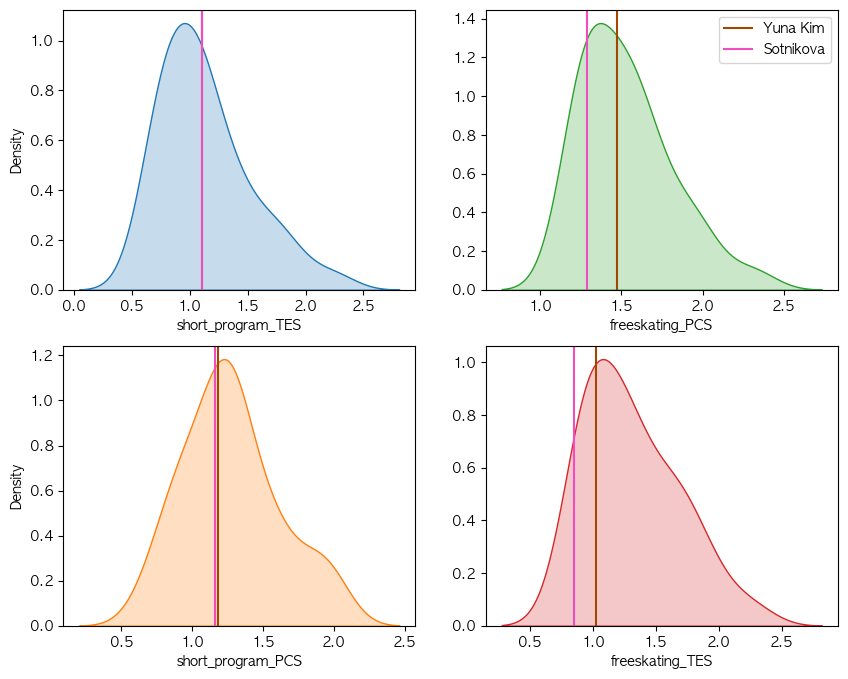

In [62]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(10, 8)
for i, col in enumerate(kld_result.columns):
    ax = axes[i % 2, i // 2]
    sns.kdeplot(kld_result[col], ax=ax, fill=True, color=sns.color_palette()[i])
    sotnikova_kld = kld_result[col]['rus-adelina_sotnikova']
    ax.axvline(x=sotnikova_kld, color=sns.color_palette('bright')[5]).set_label('Yuna Kim')
    kim_yuna_kld = kld_result[col]['kor-yuna_kim']
    ax.axvline(x=kim_yuna_kld, color=sns.color_palette('bright')[6]).set_label('Sotnikova')
    if i // 2 == 1:
        ax.set_ylabel('')
axes[0, 1].legend(loc='upper right')

## 강대국 어드벤티지 분석

In [63]:
overview_df = []
for key, df in overview.items():
    df['player_key'] = key
    overview_df.append(df)
overview_df = pd.concat(overview_df, axis=0).drop(columns=['event-url', 'short-program-link', 'freeskating-link', 'final-link', 'final-result-link'])
overview_df.sample(5)

,season,event-title,location,date,short-program-score,short-program-ranking,freeskating-score,freeskating-ranking,final-score,final-ranking,event-key,player_key
6,2008/09,Cup of Nice,Nice,2008-10-15,35.14,11,57.13,15,92.27,13,2008-Cup of Nice,aut-kerstin_frank
74,2021/22,JPN Nationals,"Saitama, Saitama",2021-12-22,111.31,1,211.05,1,322.36,1,2021-JPN Nationals,jpn-yuzuru_hanyu
36,2014/15,Universiade,Grenada,2015-02-03,44.56,12,95.25,9,139.81,12,2014-Universiade,nor-anne_line_gjersem
37,2017/18,GPFRA,Grenoble,2017-11-17,85.41,6,172.93,3.0,258.34,3,2017-GPFRA,uzb-misha_ge
30,2012/13,4CC,"Osaka, Osaka",2013-02-08,64.04,3,116.99,3,181.03,3,2012-4CC,jpn-kanako_murakami


In [64]:
overview_df['noc'] = overview_df['player_key'].str.split('-').str[0].str.upper()
overview_df['is_powerful_nation'] = overview_df['noc'].isin(powerful_nations)
overview_df.head()

,season,event-title,location,date,short-program-score,short-program-ranking,freeskating-score,freeskating-ranking,final-score,final-ranking,event-key,player_key,noc,is_powerful_nation
0,2007/08,Cup of Nice,Nice,2007-10-18,42.74,2J,65.75,5J,108.49,4J,2007-Cup of Nice,ger-nathalie_weinzierl,GER,True
1,2007/08,GER Nationals,Dresden,2008-01-03,45.46,1J,68.36,4J,113.82,2J,2007-GER Nationals,ger-nathalie_weinzierl,GER,True
2,2008/09,GER Nationals,Oberstdorf,2008-12-18,37.90,9,58.69,15,96.59,13,2008-GER Nationals,ger-nathalie_weinzierl,GER,True
3,2009/10,JGP BLR,Minsk,2009-09-23,29.84,22J,38.60,25J,68.44,24J,2009-JGP BLR,ger-nathalie_weinzierl,GER,True
4,2009/10,JGP TUR,Istanbul,2009-10-14,29.88,29J,47.45,30J,77.33,28J,2009-JGP TUR,ger-nathalie_weinzierl,GER,True


In [65]:
def get_TES_PCS_score(data: dict, df: pd.DataFrame, event: str):
    short_program_TES = []
    short_program_PCS = []
    freeskating_TES = []
    freeskating_PCS = []
    for i, row in df.iterrows():
        key = row['player_key']
        short_program = data[key][event]['short_program']
        short_program_TES.append(
            short_program['TES_score_df']['Score'].astype(float).sum()
            if short_program['total'] is not None 
            else np.nan
        )
        short_program_PCS.append(
            short_program['PCS_score']
            if short_program['PCS_score'] is not None
            else get_score(short_program['PCS_tally_df'].values)
                if short_program['PCS_tally_df'] is not None
                else np.nan
        )

        freeskating = data[key][event]['freeskating']
        if freeskating is None:
            freeskating_TES.append(np.nan)
            freeskating_PCS.append(np.nan)
            continue
        freeskating_TES.append(
            freeskating['TES_score_df']['Score'].astype(float).sum()
            if freeskating['total'] is not None 
            else np.nan
        )
        freeskating_PCS.append(
            freeskating['PCS_score']
            if freeskating['PCS_score'] is not None
            else get_score(freeskating['PCS_tally_df'].values)
                if freeskating['PCS_tally_df'] is not None
                else np.nan
        )
    result_df = pd.DataFrame({
        'short-program-TES': pd.Series(short_program_TES).astype(float),
        'short-program-PCS': pd.Series(short_program_PCS).astype(float),
        'freeskating-TES': pd.Series(freeskating_TES).astype(float),
        'freeskating-PCS': pd.Series(freeskating_PCS).astype(float),
    })
    result_df['short-program-PCS/TES'] = result_df['short-program-PCS'].values / result_df['short-program-TES'].values
    result_df['freeskating-PCS/TES'] = result_df['freeskating-PCS'].values / result_df['short-program-TES'].values

    return result_df

In [66]:
sochi_olympic_df = overview_df[overview_df['event-key'] == '2013-Olympics'].reset_index(drop=True)
sochi_olympic_df.head()

,season,event-title,location,date,short-program-score,short-program-ranking,freeskating-score,freeskating-ranking,final-score,final-ranking,event-key,player_key,noc,is_powerful_nation
0,2013/14,Olympics,Sochi,2014-02-11,57.63,10,89.73,21,147.36,18,2013-Olympics,ger-nathalie_weinzierl,GER,True
1,2013/14,Olympics,Sochi,2014-02-11,55.51,16,142.71,3,198.22,6,2013-Olympics,jpn-mao_asada,JPN,True
2,2013/14,Olympics,Sochi,2014-02-11,55.60,15,115.38,12,170.98,12,2013-Olympics,jpn-kanako_murakami,JPN,True
3,2013/14,Olympics,Sochi,2014-02-11,60.97,8,125.35,8,186.32,8,2013-Olympics,jpn-akiko_suzuki,JPN,True
4,2013/14,Olympics,Sochi,2014-02-11,68.63,4,136.90,5,205.53,4,2013-Olympics,usa-gracie_gold,USA,True


In [67]:
data['kor-yuna_kim']['2009-Olympics']['freeskating']['PCS_tally_df']

,J0,J1,J2,J3,J4,J5,J6,J7,J8
score,69.2,71.6,72.0,73.6,70.8,70.8,74.0,72.4,70.8


In [68]:
data['kor-yuna_kim']['2009-Olympics']['freeskating']['TES_score_df']['Score'].sum()

'12.007.307.703.805.409.506.358.604.305.253.604.50'

In [69]:
sochi_olympic_df.describe()

,short-program-score,freeskating-score,final-score
count,40.000000,40.000000,40.000000
mean,65.445000,108.483750,173.928750
std,14.965987,56.492691,68.953033
min,40.370000,0.000000,40.370000
25%,54.955000,91.770000,146.322500
50%,61.740000,122.635000,185.285000
75%,74.710000,146.935000,222.820000
max,101.450000,178.640000,280.090000


In [70]:
sochi_olympic_df = pd.concat([
    sochi_olympic_df,
    get_TES_PCS_score(data, sochi_olympic_df, '2013-Olympics'),
    ],
    axis=1,
)
sochi_olympic_df.head()

,season,event-title,location,date,short-program-score,short-program-ranking,freeskating-score,freeskating-ranking,final-score,final-ranking,event-key,player_key,noc,is_powerful_nation,short-program-TES,short-program-PCS,freeskating-TES,freeskating-PCS,short-program-PCS/TES,freeskating-PCS/TES
0,2013/14,Olympics,Sochi,2014-02-11,57.63,10,89.73,21,147.36,18,2013-Olympics,ger-nathalie_weinzierl,GER,True,31.94,25.69,38.47,52.26,0.804321,1.636193
1,2013/14,Olympics,Sochi,2014-02-11,55.51,16,142.71,3,198.22,6,2013-Olympics,jpn-mao_asada,JPN,True,22.63,33.88,73.03,69.68,1.497128,3.079099
2,2013/14,Olympics,Sochi,2014-02-11,55.60,15,115.38,12,170.98,12,2013-Olympics,jpn-kanako_murakami,JPN,True,26.72,28.88,56.96,58.42,1.080838,2.186377
3,2013/14,Olympics,Sochi,2014-02-11,60.97,8,125.35,8,186.32,8,2013-Olympics,jpn-akiko_suzuki,JPN,True,28.71,32.26,60.57,65.78,1.123650,2.291188
4,2013/14,Olympics,Sochi,2014-02-11,68.63,4,136.90,5,205.53,4,2013-Olympics,usa-gracie_gold,USA,True,36.55,32.08,69.57,68.33,0.877702,1.869494


In [71]:
sochi_olympic_df.isna().mean()

season                   0.000
event-title              0.000
location                 0.000
date                     0.000
short-program-score      0.000
short-program-ranking    0.000
freeskating-score        0.000
freeskating-ranking      0.175
final-score              0.000
final-ranking            0.000
event-key                0.000
player_key               0.000
noc                      0.000
is_powerful_nation       0.000
short-program-TES        0.000
short-program-PCS        0.000
freeskating-TES          0.175
freeskating-PCS          0.175
short-program-PCS/TES    0.000
freeskating-PCS/TES      0.175
dtype: float64

In [72]:
sochi_powerful_df = sochi_olympic_df[sochi_olympic_df['is_powerful_nation']]
sochi_non_powerful_df = sochi_olympic_df[~ sochi_olympic_df['is_powerful_nation']]

<Axes: ylabel='Frequency'>

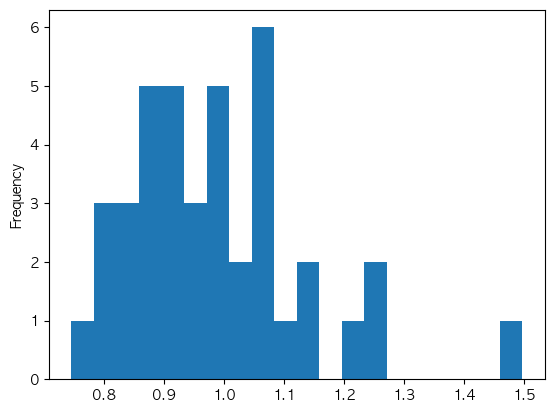

In [73]:
sochi_olympic_df['short-program-PCS/TES'].plot.hist(bins=20)

<Axes: ylabel='Frequency'>

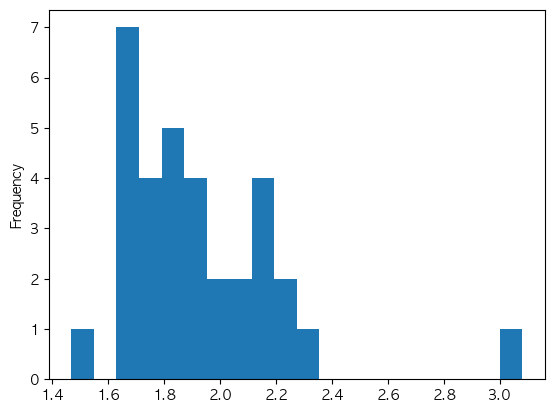

In [74]:
sochi_olympic_df['freeskating-PCS/TES'].plot.hist(bins=20)

In [75]:
stats.shapiro(sochi_olympic_df['short-program-PCS/TES'].dropna()).pvalue

np.float64(0.017689871998014823)

In [76]:
stats.shapiro(sochi_olympic_df['freeskating-PCS/TES'].dropna()).pvalue

np.float64(0.0002941618872794306)

In [77]:
_, pvalue = stats.ttest_ind(
    sochi_powerful_df['short-program-PCS/TES'].dropna(), 
    sochi_non_powerful_df['short-program-PCS/TES'].dropna(), 
    alternative='greater'
)
print(pvalue)

0.3416368474767933


In [78]:
_, pvalue = stats.ttest_ind(
    sochi_powerful_df[~ sochi_powerful_df['freeskating-PCS/TES'].isna()]['short-program-PCS/TES'].dropna(), 
    sochi_non_powerful_df[~ sochi_non_powerful_df['freeskating-PCS/TES'].isna()]['short-program-PCS/TES'].dropna(), 
    alternative='greater'
)
print(pvalue)

0.08689582120958164


In [79]:
_, sochi_pvalue = stats.ttest_ind(
    sochi_powerful_df['freeskating-PCS/TES'].dropna(), 
    sochi_non_powerful_df['freeskating-PCS/TES'].dropna(), 
    alternative='greater'
)
print(sochi_pvalue)

0.03318929333485807


In [80]:
sochi_olympic_df.columns

Index(['season', 'event-title', 'location', 'date', 'short-program-score',
       'short-program-ranking', 'freeskating-score', 'freeskating-ranking',
       'final-score', 'final-ranking', 'event-key', 'player_key', 'noc',
       'is_powerful_nation', 'short-program-TES', 'short-program-PCS',
       'freeskating-TES', 'freeskating-PCS', 'short-program-PCS/TES',
       'freeskating-PCS/TES'],
      dtype='object')

In [81]:
plot_sochi_olympic_df = sochi_olympic_df.copy()
plot_sochi_olympic_df['is_powerful_nation'] = plot_sochi_olympic_df['is_powerful_nation'].replace({True: '강국', False: '중견국'})
plot_sochi_olympic_df = plot_sochi_olympic_df.rename(columns={'is_powerful_nation': 'Powerful Nation'})

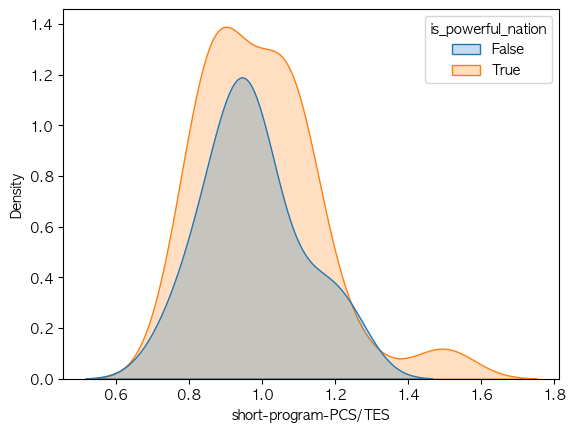

In [82]:
_ = sns.kdeplot(
    sochi_olympic_df[['is_powerful_nation', 'short-program-PCS/TES']], 
    x='short-program-PCS/TES', 
    hue='is_powerful_nation',
    fill=True,
)

Text(0.5, 0, 'Freeskating PCS/TES')

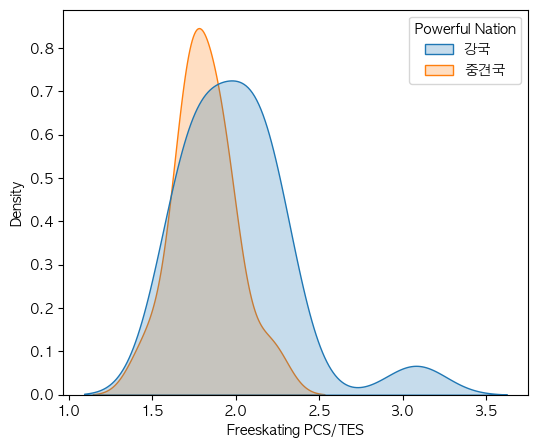

In [83]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(6)
ax = sns.kdeplot(
    plot_sochi_olympic_df[['Powerful Nation', 'freeskating-PCS/TES']], 
    x='freeskating-PCS/TES', 
    hue='Powerful Nation',
    fill=True,
    #palette='Blues',
)
ax.set_xlabel('Freeskating PCS/TES')

short program에서는 freeskating 진출 여부에 관계 없이, 강대국 어드벤티지가 적거나 거의 없다고 볼 수 있는 반면, freeskating에서는 명백히 피겨 스케이팅 강국의 선수들이 TES 대비 PCS를 더 많이 받음. 즉, 강대국 어드벤티지가 분명히 존재함.

In [84]:
sochi_olympic_df[['short-program-TES', 'short-program-PCS']].corr()

,short-program-TES,short-program-PCS
short-program-TES,1.00000,0.85423
short-program-PCS,0.85423,1.00000


<Axes: xlabel='short-program-TES', ylabel='short-program-PCS'>

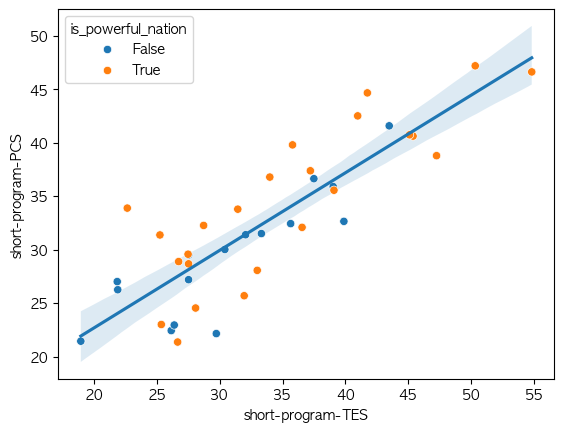

In [85]:
ax = sns.regplot(
    sochi_olympic_df[['is_powerful_nation', 'short-program-TES', 'short-program-PCS']],
    x='short-program-TES',
    y='short-program-PCS',
    scatter=False,
)
sns.scatterplot(
    sochi_olympic_df[['is_powerful_nation', 'short-program-TES', 'short-program-PCS']],
    x='short-program-TES',
    y='short-program-PCS',
    hue='is_powerful_nation',
    ax=ax,
    #palette=sns.color_palette('Blues', reverse=True)[::-1],
)

In [86]:
sochi_olympic_df[['freeskating-TES', 'freeskating-PCS']].corr()

,freeskating-TES,freeskating-PCS
freeskating-TES,1.000000,0.859817
freeskating-PCS,0.859817,1.000000


<Axes: xlabel='freeskating-TES', ylabel='freeskating-PCS'>

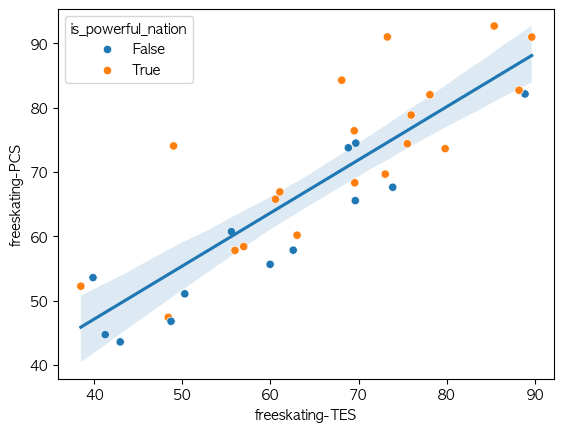

In [87]:
ax = sns.regplot(
    sochi_olympic_df[['is_powerful_nation', 'freeskating-TES', 'freeskating-PCS']],
    x='freeskating-TES',
    y='freeskating-PCS',
    scatter=False,
)
sns.scatterplot(
    sochi_olympic_df[['is_powerful_nation', 'freeskating-TES', 'freeskating-PCS']],
    x='freeskating-TES',
    y='freeskating-PCS',
    hue='is_powerful_nation',
    ax=ax,
)

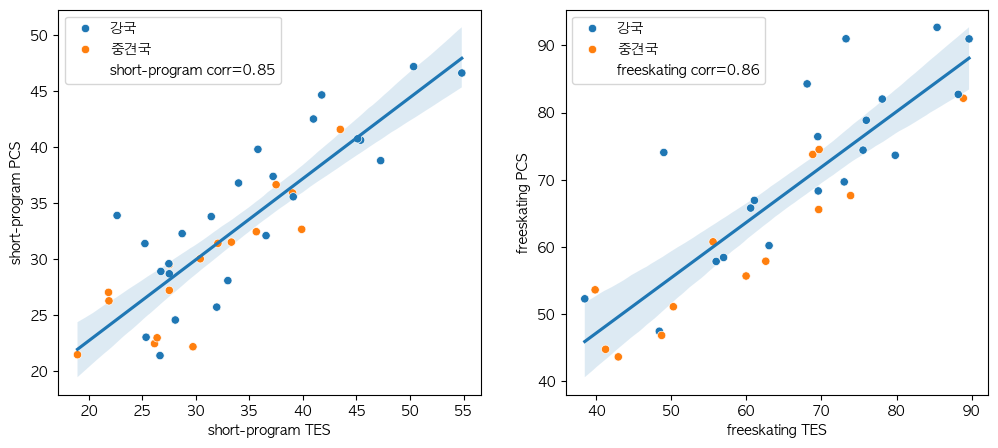

In [88]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
for i, event_type in enumerate(['short-program', 'freeskating']):
    ax = axes[i]
    sns.regplot(
        plot_sochi_olympic_df[['Powerful Nation', f'{event_type}-TES', f'{event_type}-PCS']],
        x=f'{event_type}-TES',
        y=f'{event_type}-PCS',
        scatter=False,
        ax=ax,
    )
    sns.scatterplot(
        plot_sochi_olympic_df[['Powerful Nation', f'{event_type}-TES', f'{event_type}-PCS']],
        x=f'{event_type}-TES',
        y=f'{event_type}-PCS',
        hue='Powerful Nation',
        ax=ax,
    )
    corr_value = sochi_olympic_df[[f'{event_type}-TES', f'{event_type}-PCS']].corr().iloc[0, 1]
    #ax.text(s=f"{event_type} corr={corr_value:.3}", x=0.4, y=0.1, transform=ax.transAxes)
    ax.plot([], [], ' ', label=f"{event_type} corr={corr_value:.2}")
    ax.set_xlabel(f'{event_type} TES')
    ax.set_ylabel(f'{event_type} PCS')
    ax.legend()

## 강대국 어드벤티지의 변화 양상

In [89]:
figure_skating_df.columns

Index(['edition', 'edition_id', 'country_noc', 'sport', 'event', 'result_id',
       'athlete', 'athlete_id', 'pos', 'medal', 'isTeamSport', 'event_title',
       'sport_url', 'result_date', 'result_location', 'result_participants',
       'result_format', 'result_detail', 'result_description', 'got-medal'],
      dtype='object')

In [90]:
figure_skating_df['player_key'] = figure_skating_df['country_noc'].str.lower().str.cat(figure_skating_df['athlete'].str.replace(' ', '_').str.lower(), sep='-')

In [91]:
overview_df.columns

Index(['season', 'event-title', 'location', 'date', 'short-program-score',
       'short-program-ranking', 'freeskating-score', 'freeskating-ranking',
       'final-score', 'final-ranking', 'event-key', 'player_key', 'noc',
       'is_powerful_nation'],
      dtype='object')

In [92]:
figure_skating_df.head()

,edition,edition_id,country_noc,sport,event,result_id,athlete,athlete_id,pos,medal,...,event_title,sport_url,result_date,result_location,result_participants,result_format,result_detail,result_description,got-medal,player_key
1867,1998 Winter Olympics,46,AZE,Figure Skating,"Singles, Men",14168,Igor Pashkevich,96229,16,NaN,...,"Singles, Men",/editions/46/sports/FSK,12 – 14 February 1998,"White Ring, Nagano",29 from 24 countries,"In each section, skaters were ranked on Ordina...",na,"Since Lillehammer, Elvis Stojko (CAN), silver ...",False,aze-igor_pashkevich
1868,1998 Winter Olympics,46,AZE,Figure Skating,"Singles, Women",14189,Yuliya Vorobyova,82967,16,NaN,...,"Singles, Women",/editions/46/sports/FSK,18 – 20 February 1998,"White Ring, Nagano",28 from 21 countries,"In each section, skaters were ranked on Ordina...",na,Michelle Kwan had a chance to be on the 1994 U...,False,aze-yuliya_vorobyova
1869,1998 Winter Olympics,46,AZE,Figure Skating,"Pairs, Mixed",14210,Inga Rodionova,100207,18,NaN,...,"Pairs, Mixed",/editions/46/sports/FSK,8 – 10 February 1998,"White Ring, Nagano",40 from 14 countries,The pairs were ranked on Ordinal Placement for...,na,Artur Dmitriyev (RUS) had won the pairs gold m...,False,aze-inga_rodionova
1870,1998 Winter Olympics,46,AZE,Figure Skating,"Pairs, Mixed",14210,Aleksandr Anishchenko,100208,18,NaN,...,"Pairs, Mixed",/editions/46/sports/FSK,8 – 10 February 1998,"White Ring, Nagano",40 from 14 countries,The pairs were ranked on Ordinal Placement for...,na,Artur Dmitriyev (RUS) had won the pairs gold m...,False,aze-aleksandr_anishchenko
1904,2002 Winter Olympics,47,AZE,Figure Skating,"Singles, Men",14274,Sergey Rylov,101980,24,NaN,...,"Singles, Men",/editions/47/sports/FSK,12 – 14 February 2002,"Salt Lake Ice Center, Salt Lake City, Utah",28 from 20 countries,"In each section, skaters were ranked on Ordina...",na,"The co-favorites were the two Russians, Yevgen...",False,aze-sergey_rylov


In [93]:
participated_editions = (figure_skating_df.sort_values('edition')[figure_skating_df['edition'].isin(['2010 Winter Olympics', '2014 Winter Olympics', '2018 Winter Olympics']) 
                                                                  & (~ figure_skating_df[['edition', 'athlete_id']].duplicated())
                                          ]
                                          .groupby(['athlete_id', 'athlete'])['edition']
                                          .apply(tuple)
)
participated_editions

/var/folders/l4/xcb152_d5v51k4kx19t42f0w0000gn/T/ipykernel_29862/2393394947.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  participated_editions = (figure_skating_df.sort_values('edition')[figure_skating_df['edition'].isin(['2010 Winter Olympics', '2014 Winter Olympics', '2018 Winter Olympics'])


athlete_id  athlete        
100133      Júlia Sebestyén                         (2010 Winter Olympics,)
100188      Shen Xue                                (2010 Winter Olympics,)
100189      Zhao Hongbo                             (2010 Winter Olympics,)
101231      Pang Qing          (2010 Winter Olympics, 2014 Winter Olympics)
101232      Tong Jian          (2010 Winter Olympics, 2014 Winter Olympics)
                                                   ...                     
138305      Nathan Chen                             (2018 Winter Olympics,)
138306      Zach Donohue                            (2018 Winter Olympics,)
138307      Chris Knierim                           (2018 Winter Olympics,)
138308      Adam Rippon                             (2018 Winter Olympics,)
138309      Vincent Zhou                            (2018 Winter Olympics,)
Name: edition, Length: 342, dtype: object

In [94]:
participated_editions[participated_editions.apply(len) > 1].value_counts().sort_index()

edition
(2010 Winter Olympics, 2014 Winter Olympics)                          31
(2010 Winter Olympics, 2014 Winter Olympics, 2018 Winter Olympics)    20
(2010 Winter Olympics, 2018 Winter Olympics)                           2
(2014 Winter Olympics, 2018 Winter Olympics)                          33
Name: count, dtype: int64

In [95]:
participated_editions.isin([
            ('2010 Winter Olympics', '2014 Winter Olympics'),
            ('2010 Winter Olympics', '2014 Winter Olympics', '2018 Winter Olympics'),
        ]).index.get_level_values('athlete_id')

Index([100133, 100188, 100189, 101231, 101232, 101235, 101236, 101237, 101243,
       101244,
       ...
       138244, 138301, 138302, 138303, 138304, 138305, 138306, 138307, 138308,
       138309],
      dtype='int64', name='athlete_id', length=342)

In [96]:
vancouver_sochi = figure_skating_df[
    figure_skating_df['athlete_id'].isin(
        participated_editions.isin([
            ('2010 Winter Olympics', '2014 Winter Olympics'),
            ('2010 Winter Olympics', '2014 Winter Olympics', '2018 Winter Olympics'),
        ])
        .index
        .get_level_values('athlete_id')
        )
]
vancouver_sochi.head()

,edition,edition_id,country_noc,sport,event,result_id,athlete,athlete_id,pos,medal,...,event_title,sport_url,result_date,result_location,result_participants,result_format,result_detail,result_description,got-medal,player_key
2059,2014 Winter Olympics,58,AZE,Figure Skating,"Ice Dancing, Mixed",350316,Yuliya Zlobina,127391,12,NaN,...,"Ice Dancing, Mixed",/editions/58/sports/FSK,16 – 17 February 2014,"Dvorets Zimnego Sporta Aisberg, Coastal Cluste...",48 from 15 countries,"Total of points from compulsory dance, optiona...",na,The gold and silver medals were somewhat pre-o...,False,aze-yuliya_zlobina
2060,2014 Winter Olympics,58,AZE,Figure Skating,"Ice Dancing, Mixed",350316,Aleksey Sitnikov,127392,12,NaN,...,"Ice Dancing, Mixed",/editions/58/sports/FSK,16 – 17 February 2014,"Dvorets Zimnego Sporta Aisberg, Coastal Cluste...",48 from 15 countries,"Total of points from compulsory dance, optiona...",na,The gold and silver medals were somewhat pre-o...,False,aze-aleksey_sitnikov
9106,2010 Winter Olympics,57,PRK,Figure Skating,"Singles, Men",924265,Ri Song-Chol,119123,25 r1/2,NaN,...,"Singles, Men",/editions/57/sports/FSK,16 – 18 February 2010,"Pacific Coliseum, Vancouver",30 from 20 countries,Total of points from short program and free sk...,na,"After winning the 2006 gold medal, Yevgeny Ply...",False,prk-ri_song-chol
9217,2018 Winter Olympics,60,PRK,Figure Skating,"Pairs, Mixed",9000636,Ryom Tae-Ok,137942,13,NaN,...,"Pairs, Mixed",/editions/60/sports/FSK,14 – 15 February 2018 — 10:00,"Gangneung Ice Arena, Gangneung Olympic Park, C...",44 from 14 countries,Total of points from short program and free sk...,na,Originally only 20 spots were available at the...,False,prk-ryom_tae-ok
9218,2018 Winter Olympics,60,PRK,Figure Skating,"Pairs, Mixed",9000636,Kim Ju-Sik,137943,13,NaN,...,"Pairs, Mixed",/editions/60/sports/FSK,14 – 15 February 2018 — 10:00,"Gangneung Ice Arena, Gangneung Olympic Park, C...",44 from 14 countries,Total of points from short program and free sk...,na,Originally only 20 spots were available at the...,False,prk-kim_ju-sik


In [97]:
vancouver_olympic_df = overview_df[overview_df['event-key'] == '2009-Olympics'].reset_index(drop=True)
vancouver_olympic_df = pd.concat([
    vancouver_olympic_df,
    get_TES_PCS_score(data, vancouver_olympic_df, '2009-Olympics'),
    ],
    axis=1,
)
vancouver_olympic_df.head()

,season,event-title,location,date,short-program-score,short-program-ranking,freeskating-score,freeskating-ranking,final-score,final-ranking,event-key,player_key,noc,is_powerful_nation,short-program-TES,short-program-PCS,freeskating-TES,freeskating-PCS,short-program-PCS/TES,freeskating-PCS/TES
0,2009/10,Olympics,"Vancouver, BC",2010-02-12,73.78,2,131.72,2,205.50,2,2009-Olympics,jpn-mao_asada,JPN,True,41.50,32.28,64.68,67.04,0.777831,1.615422
1,2009/10,Olympics,"Vancouver, BC",2010-02-12,61.02,11,120.42,7,181.44,8,2009-Olympics,jpn-akiko_suzuki,JPN,True,33.10,27.92,60.98,59.44,0.843505,1.795770
2,2009/10,Olympics,"Vancouver, BC",2010-02-12,51.95,29,0.00,NaN,51.95,29,2009-Olympics,rou-zoltan_kelemen,ROU,False,27.40,25.55,NaN,NaN,0.932482,NaN
3,2009/10,Olympics,"Vancouver, BC",2010-02-12,81.12,7,160.30,4,241.42,5,2009-Olympics,can-patrick_chan,CAN,True,41.42,40.70,79.30,82.00,0.982617,1.979720
4,2009/10,Olympics,"Vancouver, BC",2010-02-12,60.88,23,115.05,20,175.93,21,2009-Olympics,aut-viktor_pfeifer,AUT,True,34.08,26.80,61.25,54.80,0.786385,1.607981


In [98]:
vancouver_olympic_df[['short-program-TES', 'short-program-PCS']].corr()

,short-program-TES,short-program-PCS
short-program-TES,1.000000,0.668297
short-program-PCS,0.668297,1.000000


In [99]:
vancouver_olympic_df[['freeskating-TES', 'freeskating-PCS']].corr()

,freeskating-TES,freeskating-PCS
freeskating-TES,1.00000,0.75962
freeskating-PCS,0.75962,1.00000


In [100]:
stats.shapiro(vancouver_olympic_df['short-program-PCS/TES'].dropna()).pvalue

np.float64(0.06015326503424174)

In [101]:
stats.shapiro(vancouver_olympic_df['freeskating-PCS/TES'].dropna()).pvalue

np.float64(0.006772449895459275)

In [102]:
vancouver_powerful_df = vancouver_olympic_df[vancouver_olympic_df['is_powerful_nation']]
vancouver_non_powerful_df = vancouver_olympic_df[~ vancouver_olympic_df['is_powerful_nation']]

In [103]:
_, pvalue = stats.ttest_ind(
    vancouver_powerful_df['short-program-PCS/TES'].dropna(), 
    vancouver_non_powerful_df['short-program-PCS/TES'].dropna(), 
    alternative='greater'
)
print(pvalue)

0.10186834785512348


In [104]:
_, vancouver_pvalue = stats.ttest_ind(
    vancouver_powerful_df['freeskating-PCS/TES'].dropna(), 
    vancouver_non_powerful_df['freeskating-PCS/TES'].dropna(), 
    alternative='greater'
)
print(vancouver_pvalue)

0.0644750814903268


In [105]:
pyeongchang_olympic_df = overview_df[overview_df['event-key'] == '2017-Olympics'].reset_index(drop=True)
pyeongchang_olympic_df = pd.concat([
    pyeongchang_olympic_df,
    get_TES_PCS_score(data, pyeongchang_olympic_df, '2017-Olympics'),
    ],
    axis=1,
)
pyeongchang_olympic_df.head()

,season,event-title,location,date,short-program-score,short-program-ranking,freeskating-score,freeskating-ranking,final-score,final-ranking,event-key,player_key,noc,is_powerful_nation,short-program-TES,short-program-PCS,freeskating-TES,freeskating-PCS,short-program-PCS/TES,freeskating-PCS/TES
0,2017/18,Olympics,PyeongChang,2018-02-14,83.06,16,150.75,21,233.81,20,2017-Olympics,aus-brendan_kerry,AUS,False,45.49,37.57,73.33,77.42,0.825896,1.701913
1,2017/18,Olympics,PyeongChang,2018-02-14,90.01,6,173.42,8,263.43,9,2017-Olympics,can-patrick_chan,CAN,True,45.08,45.93,81.56,91.86,1.018855,2.037711
2,2017/18,Olympics,PyeongChang,2018-02-14,73.15,6,139.29,5,212.44,5,2017-Olympics,ita-carolina_kostner,ITA,False,35.06,38.09,63.64,75.65,1.086423,2.157730
3,2017/18,Olympics,PyeongChang,2018-02-14,68.90,7,103.56,19,172.46,15,2017-Olympics,can-gabrielle_daleman,CAN,True,35.90,33.00,45.81,61.75,0.919220,1.720056
4,2017/18,Olympics,PyeongChang,2018-02-14,111.68,1,206.17,2,317.85,1,2017-Olympics,jpn-yuzuru_hanyu,JPN,True,63.18,48.50,109.55,96.62,0.767648,1.529281


In [106]:
pyeongchang_olympic_df[['short-program-TES', 'short-program-PCS']].corr()

,short-program-TES,short-program-PCS
short-program-TES,1.000000,0.806861
short-program-PCS,0.806861,1.000000


In [107]:
pyeongchang_olympic_df[['freeskating-TES', 'freeskating-PCS']].corr()

,freeskating-TES,freeskating-PCS
freeskating-TES,1.000000,0.931806
freeskating-PCS,0.931806,1.000000


In [108]:
pyeongchang_powerful_df = pyeongchang_olympic_df[pyeongchang_olympic_df['is_powerful_nation']]
pyeongchang_non_powerful_df = pyeongchang_olympic_df[~ pyeongchang_olympic_df['is_powerful_nation']]

In [109]:
print(
    vancouver_powerful_df['short-program-PCS/TES'].mean() - vancouver_non_powerful_df['short-program-PCS/TES'].mean(),
    vancouver_powerful_df['freeskating-PCS/TES'].mean() - vancouver_non_powerful_df['freeskating-PCS/TES'].mean(),
)

0.11652131155198853 0.30428661427949577


In [110]:
print(
    sochi_powerful_df['short-program-PCS/TES'].mean() - sochi_non_powerful_df['short-program-PCS/TES'].mean(),
    sochi_powerful_df['freeskating-PCS/TES'].mean() - sochi_non_powerful_df['freeskating-PCS/TES'].mean(),
)

0.019930680597101125 0.19082636900499006


In [111]:
print(
    pyeongchang_powerful_df['short-program-PCS/TES'].mean() - pyeongchang_non_powerful_df['short-program-PCS/TES'].mean(),
    pyeongchang_powerful_df['freeskating-PCS/TES'].mean() - pyeongchang_non_powerful_df['freeskating-PCS/TES'].mean(),
)

-0.10841308234757174 -0.12935571882202868


In [112]:
_, pvalue = stats.ttest_ind(
    pyeongchang_powerful_df['short-program-PCS/TES'].dropna(), 
    pyeongchang_non_powerful_df['short-program-PCS/TES'].dropna(), 
    alternative='greater'
)
print(pvalue)

0.883515108170655


In [113]:
_, pyeongchang_pvalue = stats.ttest_ind(
    pyeongchang_powerful_df['freeskating-PCS/TES'].dropna(), 
    pyeongchang_non_powerful_df['freeskating-PCS/TES'].dropna(), 
    alternative='greater'
)
print(pyeongchang_pvalue)

0.8335608816850378
